# Monitoring of model
 Evaluate model on data and obtain metrics of performance

## Load libraries

In [1]:
pip install tabgan==1.3.3

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install lightgbm

In [3]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install scipy==1.11.4

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install --upgrade pandas "dask[complete]"

Note: you may need to restart the kernel to use updated packages.


In [6]:
## librerias requeridas
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import re
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_lift_curve
from scikitplot.helpers import binary_ks_curve 
from scikitplot.metrics import plot_ks_statistic
from scikitplot.helpers import cumulative_gain_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from datetime import datetime, timedelta

import pyarrow as pa
import pyarrow.parquet as pq

In [7]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.memory_usage', True)

## Load model and data to evaluate

Load variables names from file

In [8]:
import os
os.getcwd()

'/home/ec2-user/SageMaker/viamericas-dev/Analytics/5.Fraud'

In [9]:
import os
import joblib
# load model
#modelo = joblib.load("ModeloV2TodosMenosVariables.pkl") 
#variables = open('./ModeloV2TodosMenosVariables.txt','r')
modelo = joblib.load("ModeloFinal2.pkl") 
variables = open('./ModeloFinal2.txt','r')

In [10]:
modelo

LGBMClassifier(colsample_bytree=0.84, importance_type='gini',
               learning_rate=0.07, max_depth=20, min_child_weight=0.0026,
               n_estimators=520, num_leaves=30, objective='binary',
               scale_pos_weight=0.003, subsample=1)

## Veo si puedo sacar los nombres directo del modelo q cargue
## Veo como cargar el punto de corte

In [11]:
variables = open('./ModeloFinal2.txt','r')
var_input = variables.read()

In [12]:
var_input = ['01_branch_working_days', 'branch_minutes_since_last_transaction',
    'branch_trans_3m', 'branch_has_fraud', 
    'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_40min', 
    'location_nro_fraud', 'sender_trans_3m', 
    'sender_nro_fraud','01_isMexico', 
    '01_sender_branch_state', '01_var_range_hist',
    '01_branch_fraud', '01_location_fraud', '01_sender_fraud', 
    '01_isCashPick', '01_isBankDep', 
    'sender_days_to_last_transaction_more7m', 
    '01_receiver_transaction_count', '01_sender_sending_days',
    '01_branch_working_days', '01_net_amount_receiver', 
    '01_sender_minutes_since_last_transaction_2days', 
    '01_sender_days_to_last_transaction_365', 
    '01_sender_days_to_last_transaction_7m', '01_hour_receiver']

In [13]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
dfTrain = pd.read_parquet(f"s3://{s3_url}/Train/Train.parquet")
tgTrain = dfTrain['target']

dfVal = pd.read_parquet(f"s3://{s3_url}/Validation/Validation.parquet")
tgVal = dfVal['target']

#Uni test y Val
#X = pd.concat([dfTrain[var_input], dfVal[var_input]], ignore_index=True) 
X = pd.concat([dfTrain, dfVal], ignore_index=True) 
Y = pd.DataFrame(pd.concat([dfTrain['target'], dfVal['target']], ignore_index=True)) 

dias_target = ['day_name_receiver_0', 'day_name_receiver_1',
       'day_name_receiver_2', 'day_name_receiver_3',
       'day_name_receiver_4', 'day_name_receiver_5',
       'day_name_receiver_6','target']

testeo =  pd.concat([X, Y], axis=1)
Y_target = pd.DataFrame(pd.concat([dfTrain[dias_target], dfVal[dias_target]], ignore_index=True)) 

In [14]:
# Uso esto para sacar el punto de corte. Cuando lo pueda guardar esta celda se va
# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = modelo.predict_proba(testeo[var_input])

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)

# Creando una copia del DataFrame 'Y_c' para preservar los datos originales
Y_c = Y_target.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_c['score_rf'] = score_rf

#Calculo el primer percentil para sacar el punto de corte
percentiles = pd.qcut(Y_c['score_rf'], q=1000, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')

#saco el punto de corte del primer centil para aplicarlo al test
corte_01 = Y_c.score_rf[Y_c['FRAUD_DECILE']==1].min()
corte_02 = Y_c.score_rf[Y_c['FRAUD_DECILE']==2].min()
corte_03 = Y_c.score_rf[Y_c['FRAUD_DECILE']==3].min()
corte_04 = Y_c.score_rf[Y_c['FRAUD_DECILE']==4].min()
corte = Y_c.score_rf[Y_c['FRAUD_DECILE']==10].min()

In [15]:
corte

1.976573014763343e-08

In [16]:
corte_01

1.1511944114690123e-06

In [18]:
Y_c['pred_corte'] = Y_c['score_rf']>corte_01
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['pred_corte']))

,0,1
0,16708132,16373
1,12,351


In [19]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
tes = pd.read_parquet(f"s3://{s3_url}/Test/Test.parquet")

testeo = pd.concat([X, tes], axis = 0, ignore_index=True)
Y_target = pd.DataFrame(pd.concat([Y_target, tes[dias_target]], ignore_index=True)) 

## Apply model

In [20]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe

testeo = limpiar_nombres_columnas(testeo)

In [21]:
testeo['target'].value_counts(dropna=False)

target
False    26478431
True          480
Name: count, dtype: int64

In [22]:
Y_target.shape

(26478911, 8)

In [23]:
#replace nan with 0
testeo['01_sender_minutes_since_last_transaction_2days'] = testeo['01_sender_minutes_since_last_transaction_2days'].fillna(0)
testeo['01_sender_days_to_last_transaction_365'] = testeo['01_sender_days_to_last_transaction_365'].fillna(0)
testeo['01_sender_days_to_last_transaction_7m'] = testeo['01_sender_days_to_last_transaction_7m'].fillna(0)

In [24]:
# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = modelo.predict_proba(testeo[var_input])

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)


In [25]:
# Creando una copia del DataFrame 'Y_TESTEO' para preservar los datos originales
Y_c = Y_target.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_c['score_rf'] = score_rf

In [26]:
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['preds_rf']))

,0,1
0,26478372,59
1,403,77


In [27]:
Y_c['pred_corte'] = Y_c['score_rf']>corte
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['pred_corte']))

,0,1
0,26260884,217547
1,27,453


<Axes: xlabel='score_rf', ylabel='Count'>

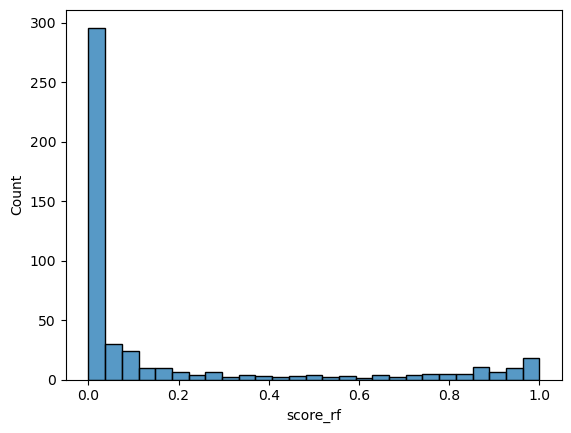

In [28]:
import seaborn as sns
sns.histplot(data = Y_c[Y_c['target'] == True], x='score_rf')

In [29]:
# Dividir las predicciones en deciles y calcular la captura del 30% en el conjunto de entrenamiento
percentiles = pd.qcut(Y_c['score_rf'], q=100, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')
print('FRAUD CAPTURA 30%:')
print(sum(Y_c[Y_c['FRAUD_DECILE'] < 4]['target']) / sum(Y_c['target']))

FRAUD CAPTURA 30%:
0.9708333333333333


In [30]:
DECILES = pd.crosstab(Y_c['FRAUD_DECILE'], Y_c['target'])
DECILES

target,False,True
FRAUD_DECILE,,
1,264337,453
2,264780,9
3,264785,4
4,264788,1
5,264785,4
...,...,...
96,264789,0
97,264789,0
98,264789,0


In [31]:
Y_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': [ 'min', 'max']}) 

score_rf              
                       min           max
FRAUD_DECILE                            
1             1.436655e-08  9.999999e-01
2             4.614386e-09  1.436636e-08
3             2.370473e-09  4.614379e-09
4             1.473776e-09  2.370470e-09
5             1.017535e-09  1.473776e-09
...                    ...           ...
96            5.191630e-13  6.236361e-13
97            4.148909e-13  5.191630e-13
98            3.079088e-13  4.148906e-13
99            1.921570e-13  3.079082e-13
100           1.787409e-15  1.921566e-13

[100 rows x 2 columns]

In [32]:
#PERC = pd.crosstab(Y_c.FRAUD_DECILE[testeo['mes']>8], Y_c.target[testeo['mes']>8])
#PERC.to_csv ('./percentiles.csv')

## Analizo distintos puntos de corte

In [33]:
testeo['date_receiver'].dt.month
testeo['year'] = testeo['date_receiver'].dt.year
Y_c['fraud_classification'] = testeo['fraud_classification']
Y_c['targetF'] = (testeo['fraud_classification']=='Real')

In [34]:
#Veo cuantos falsos positivos tengo con el punto de corte
Y_c['pred_corte_01'] = Y_c['score_rf']>corte_01
tes_corte_01 = testeo[Y_c['pred_corte_01']==True]
Y_c_corte_01 = Y_c[Y_c['pred_corte_01']==True]

pd.crosstab(tes_corte_01['mes'], Y_c_corte_01['targetF'])

targetF,False,True
mes,,
1,1059,62
2,1233,34
3,1495,21
4,1422,61
5,1395,42
6,1338,64
7,1378,29
8,1469,36
9,1718,21


In [35]:
#Veo cuantos falsos positivos tengo con el punto de corte
Y_c['pred_corte_02'] = Y_c['score_rf']>corte_02
tes_corte_02 = testeo[Y_c['pred_corte_02']==True]
Y_c_corte_02 = Y_c[Y_c['pred_corte_02']==True]

pd.crosstab(tes_corte_02['mes'], Y_c_corte_02['targetF'])

targetF,False,True
mes,,
1,2313,63
2,2692,34
3,3112,21
4,3040,61
5,3078,43
6,2938,65
7,3019,30
8,3078,37
9,3603,27


In [36]:
#Veo cuantos falsos positivos tengo con el punto de corte
Y_c['pred_corte_03'] = Y_c['score_rf']>corte_03
tes_corte_03 = testeo[Y_c['pred_corte_03']==True]
Y_c_corte_03 = Y_c[Y_c['pred_corte_03']==True]

pd.crosstab(tes_corte_03['mes'], Y_c_corte_03['targetF'])

targetF,False,True
mes,,
1,3673,63
2,4226,34
3,4811,21
4,4682,61
5,4856,43
6,4637,65
7,4826,30
8,4836,37
9,5485,28


In [37]:
#Veo cuantos falsos positivos tengo con el punto de corte
Y_c['pred_corte_04'] = Y_c['score_rf']>corte_04
tes_corte_04 = testeo[Y_c['pred_corte_04']==True]
Y_c_corte_04 = Y_c[Y_c['pred_corte_04']==True]

pd.crosstab(tes_corte_04['mes'], Y_c_corte_04['targetF'])

targetF,False,True
mes,,
1,4982,63
2,5867,34
3,6675,21
4,6385,61
5,6638,44
6,6364,68
7,6642,30
8,6497,37
9,7508,32


## Curva ROC y FP

In [38]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_lift_curve
from scikitplot.helpers import binary_ks_curve
from scikitplot.metrics import plot_ks_statistic
from scikitplot.helpers import cumulative_gain_curve

In [39]:
# Calcular la curva de ganancia acumulativa y el LIFT del modelo en el conjunto de entrenamiento
classes = np.unique(Y_c[['target']])
percentages, gains = cumulative_gain_curve(Y_c[['target']], Y_c['score_rf'], classes[1])
percentages = percentages[1:]
gains = gains[1:]
gains = gains / percentages
indice = round(len(gains) * 0.1)
print('LIFT FRAUD TESTEO:')
print(gains[indice])

# Calcular el área bajo la curva ROC del modelo en el conjunto de entrenamiento
print('ROC FRAUD TESTEO:')
print(roc_auc_score(Y_c[['target']], Y_c['pred_corte']))

# Calcular la estadística KS del modelo en el conjunto de entrenamiento
thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(Y_c[['target']], Y_c['score_rf'])
print('KS FRAUD TESTEO:')
print(ks_statistic)

# Calcular la precisión y el recall del modelo en el conjunto de entrenamiento
precision = precision_score(Y_c[['target']], Y_c['pred_corte'])
recall = recall_score(Y_c[['target']], Y_c['pred_corte'])
print('Precision FRAUD TESTEO:')
print(precision)
print('Recall FRAUD TESTEO:')
print(recall)

LIFT FRAUD TESTEO:
9.958329948565375
ROC FRAUD TESTEO:
0.9677669960174378


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KS FRAUD TESTEO:
0.943387545555475
Precision FRAUD TESTEO:
0.0020779816513761466
Recall FRAUD TESTEO:
0.94375


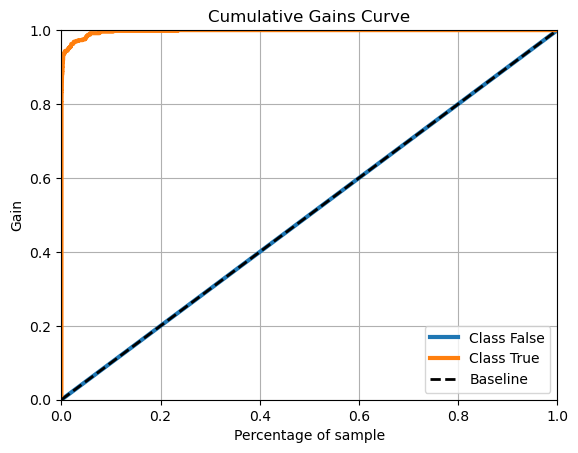

In [40]:
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_true=Y_c[['target']], y_probas =  probab_rf)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


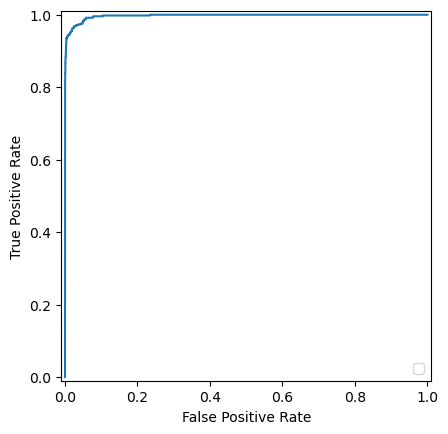

In [41]:
from sklearn.metrics import RocCurveDisplay, roc_curve

fpr, tpr, _ = roc_curve(Y_c[['target']], score_rf)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

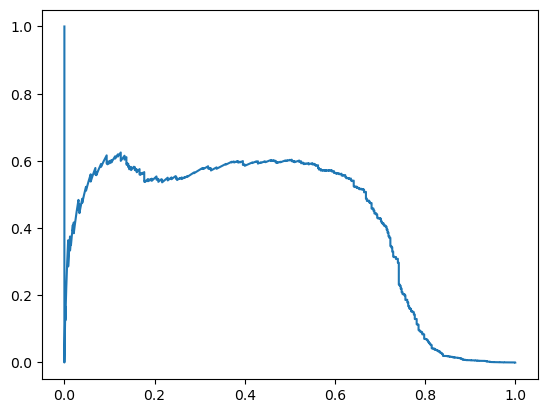

In [42]:
precision, recall, thresholds = skplt.metrics.precision_recall_curve(Y_c[['target']], score_rf)
plt.plot(recall, precision)

In [43]:
recall[recall>0.8].min() # 0.8010540184453228
precision[precision>0.8].min() #0.8002832861189801

1.0

## Monthly analysis

In [44]:
pd.crosstab(testeo['mes'], Y_c['target'])

target,False,True
mes,,
1,1717264,64
2,1765435,34
3,2030746,22
4,2116230,61
5,2289916,45
6,2193694,70
7,2314244,30
8,2296976,37
9,2420699,44


In [45]:
#Veo cuantos falsos positivos tengo con el punto de corte
tes_corte = testeo[Y_c['pred_corte']==True]
Y_c_corte = Y_c[Y_c['pred_corte']==True]

pd.crosstab(tes_corte['mes'], Y_c_corte['target'])

target,False,True
mes,,
1,13976,64
2,15872,34
3,18027,22
4,16976,61
5,18478,45
6,17832,69
7,18383,30
8,17584,37
9,20172,34


In [46]:
Tabla_mes = pd.DataFrame(pd.concat([testeo['mes'],testeo['fraud_classification'], 
                                     Y_c['FRAUD_DECILE'], Y_c['target']],axis=1))

In [47]:
Tabla_mes[Tabla_mes['target']==True]
pd.crosstab(Tabla_mes.mes, Tabla_mes.FRAUD_DECILE)

FRAUD_DECILE,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
mes,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,16991,16600,16509,16669,16349,16335,16581,16428,16429,16395,16355,16562,16517,16382,16461,16422,16401,16283,16427,16468,16342,16357,16676,16389,16146,16350,16278,16411,16371,16453,16504,16562,16429,16523,16188,16248,16377,16374,16417,16403,16335,16516,16776,16589,16615,16525,16422,16379,16394,16792,16515,16772,16614,16820,16570,16800,16643,16741,16688,16830,17028,16865,16848,16856,17138,16991,16987,16921,17020,17142,17412,17296,17402,17580,17430,17444,17375,17516,17690,17760,17832,17912,18209,18291,18186,18471,18328,18311,18578,18574,18599,18747,18938,19119,19449,19722,19955,20585,21389,23734
2,19114,18492,17711,17659,17390,17595,17672,17421,17410,17326,17200,17308,16915,17172,17128,17253,17266,17035,17032,17356,16809,16796,17105,17015,17128,16939,17391,17058,16974,16876,16642,16893,16809,16697,17116,16730,16907,16917,17021,17112,16812,16805,16865,16916,16994,17024,17039,16724,17058,16880,16864,17065,17437,17133,17184,17210,17040,17083,17221,17264,17156,17192,17166,17536,17403,17506,17204,17470,17293,17529,17657,17688,17870,17884,17850,17921,18070,18487,18053,18386,18364,18520,18166,18571,18531,18663,18874,18714,18849,19061,18963,19097,19115,19459,19409,19660,19613,20045,20489,20977
3,21790,20763,20691,20439,19905,19896,19872,19903,19564,19454,19455,19391,19636,19466,19607,19223,19232,18941,19420,19047,19308,19067,19086,19353,19169,19037,18920,18835,18923,18928,18807,18676,19064,19074,18941,18931,18929,18823,18902,18916,19123,18806,19030,18813,18655,18963,19094,19041,18726,18939,18991,19019,18756,19328,18984,19363,19192,19018,19079,19362,19410,19351,19418,19647,19519,19536,20054,19897,19903,20036,20178,20220,20325,20457,20469,20624,20831,20739,20743,21022,21203,21570,21989,21914,22129,22020,22316,22957,22829,23261,23550,23804,24079,24489,24715,24938,25477,25924,26399,27160
4,20515,19666,19468,19292,18944,18945,19180,19054,19124,18934,18802,18900,18978,18821,18992,19260,18671,19031,18818,18559,18529,18709,18913,18538,18925,18742,18821,18825,18847,18943,18879,18702,18961,18958,19009,18828,19214,19058,19048,19064,19129,19018,18990,19351,19415,19130,19157,19524,19390,19495,19383,19545,19505,19713,19705,19839,19968,20171,20289,20229,20227,20438,20363,20725,20635,20569,20920,21007,21183,21117,21479,21511,21887,21873,22033,22071,22408,22520,23039,22873,23261,23655,23807,23903,24336,24683,24836,25301,25810,26096,26421,26734,27385,27786,28626,29126,29956,30766,31917,32595
5,22577,22533,22347,22327,22376,22040,21990,21769,22041,22035,21931,21815,21738,21442,21451,21755,21291,21471,21582,21522,21630,21572,21395,21446,21423,21191,21517,21580,21498,21429,21279,21654,21455,21393,21336,21506,21439,21542,21479,21486,21444,21606,21486,21402,21704,21487,21635,21703,21775,21816,21895,21698,21843,21889,21736,21661,22022,21829,22007,22194,22332,22322,22383,22366,22343,22371,22587,22743,23127,22839,22914,22984,23051,23453,23496,23641,23649,23554,23901,24361,24065,24398,24439,24999,25146,25355,25257,25268,25894,26089,26346,26449,26662,27123,27368,27245,28466,28590,29168,29102
6,21926,22766,22832,23137,22957,22886,22735,23012,22856,22820,22739,22774,22691,22562,22486,22405,22472,22516,22369,22230,22432,22312,22229,22154,22034,22119,21812,22142,22029,21678,21997,21959,21700,21836,21847,21812,21930,22039,21724,21775,21611,21625,21527,21460,21364,21495,21210,21431,21462,21134,21524,21565,21153,21115,21266,21284,21189,21378,21095,21224,21100,21002,21329,21134,21193,21279,21448,21369,21384,21336,21030,21349,21151,21212,21201,21560,21629,21501,21456,21472,21538,21465,21714,21478,21621,21647,21996,21913,22103,21961,22101,22324,22595,22238,22620,23379,232

In [48]:
pd.crosstab(Tabla_mes.mes[Tabla_mes['target']==True], Tabla_mes.FRAUD_DECILE[Tabla_mes['target']==True])

FRAUD_DECILE,1,2,3,4,5,6,8,11,24
mes,,,,,,,,,
1,64,0,0,0,0,0,0,0,0
2,34,0,0,0,0,0,0,0,0
3,22,0,0,0,0,0,0,0,0
4,61,0,0,0,0,0,0,0,0
5,45,0,0,0,0,0,0,0,0
6,69,0,0,0,1,0,0,0,0
7,30,0,0,0,0,0,0,0,0
8,37,0,0,0,0,0,0,0,0
9,34,2,1,0,1,3,2,0,1


In [49]:
Tabla_mes.loc[Tabla_mes['target']==True,['mes','fraud_classification','FRAUD_DECILE']]

,mes,fraud_classification,FRAUD_DECILE
18834,1,Real,1
29264,6,Real,1
124527,2,Real,1
357990,3,Real,1
392994,5,Real,1
...,...,...,...
26098568,12,Real,1
26128798,12,Real,1
26188082,12,Real,1
26302599,12,Real,3


# Monthly indicators

In [58]:
i = 0
summary_metrics = pd.DataFrame(columns = ['month','year', 'precision', 'recall','alerts','frauds&dist','frauds','detected'] )
for y in  testeo['year'].unique():
    for m in  testeo['mes'].unique():
        
        subset_mes = Y_c[(testeo['year']==y) & (testeo['mes']==m)]
        precision = precision_score(subset_mes[['targetF']], subset_mes['pred_corte_02'])
        recall = recall_score(subset_mes[['targetF']], subset_mes['pred_corte_02'])
        summary_metrics.loc[i,'month'] = m
        summary_metrics.loc[i,'year'] = y
        summary_metrics.loc[i,'precision'] = precision
        summary_metrics.loc[i,'recall'] = recall
        summary_metrics.loc[i,'alerts'] = subset_mes['pred_corte_02'].sum()
        summary_metrics.loc[i,'frauds'] = subset_mes['target'].sum()
        summary_metrics.loc[i,'frauds&dist'] = subset_mes['target'].sum()
        summary_metrics.loc[i,'frauds'] = (subset_mes['fraud_classification']=='Real').sum()
        summary_metrics.loc[i,'detected'] = ((subset_mes['pred_corte_02']==True) & (subset_mes['target']==True) & (subset_mes['fraud_classification']=='Real')).sum()
        #print ('Year:', y, 'Month:',m)
        #print ('Precision:', precision, 'Recall:',recall)
        i = i+1
summary_metrics.sort_values('month')

,month,year,precision,recall,alerts,frauds&dist,frauds,detected
6,1,2023,0.026515,0.984375,2376,64,64,63
0,2,2023,0.012472,1.0,2726,34,34,34
5,3,2023,0.006703,0.954545,3133,22,22,21
1,4,2023,0.019671,1.0,3101,61,61,61
2,5,2023,0.013778,0.955556,3121,45,45,43
3,6,2023,0.021645,0.928571,3003,70,70,65
4,7,2023,0.009839,1.0,3049,30,30,30
7,8,2023,0.011878,1.0,3115,37,37,37
8,9,2023,0.007438,0.613636,3630,44,44,27
9,10,2023,0.006585,0.71875,3493,33,32,23


In [51]:
summary_metrics.sort_values('month')

,month,year,precision,recall,alerts,frauds&dist,frauds,detected
6,1,2023,0.055308,0.96875,1121,64,64,62
0,2,2023,0.026835,1.0,1267,34,34,34
5,3,2023,0.013852,0.954545,1516,22,22,21
1,4,2023,0.041133,1.0,1483,61,61,61
2,5,2023,0.029228,0.933333,1437,45,45,42
3,6,2023,0.045649,0.914286,1402,70,70,64
4,7,2023,0.020611,0.966667,1407,30,30,29
7,8,2023,0.02392,0.972973,1505,37,37,36
8,9,2023,0.012076,0.477273,1739,44,44,21
9,10,2023,0.012399,0.625,1613,33,32,20


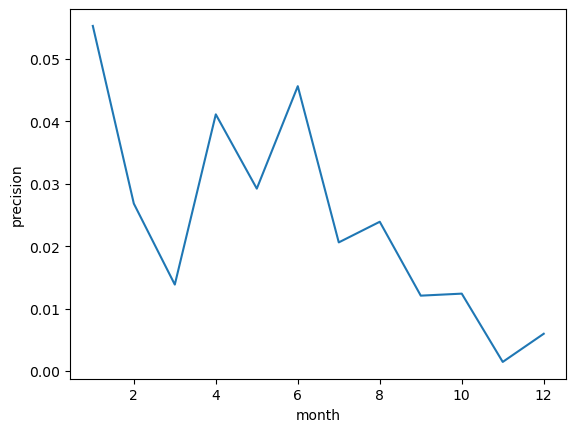

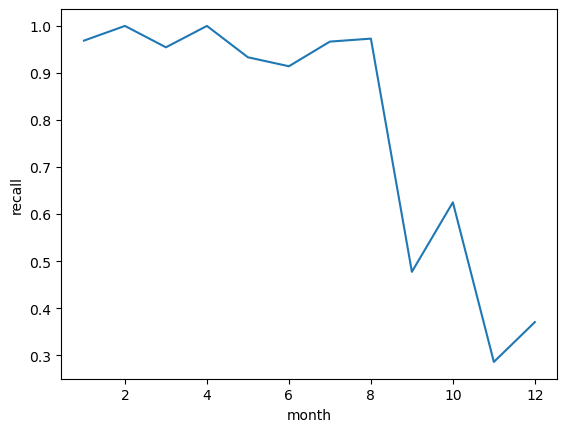

In [52]:
# Recall and precision by month
sns.lineplot(data = summary_metrics, x ='month', y = 'precision')
plt.show()
sns.lineplot(data = summary_metrics, x ='month', y= 'recall')
plt.show()

## Daily analysis

In [53]:
tes_corte_01['date_receiver'].dt.floor('d')

2881       2023-03-06
3808       2023-04-03
6147       2023-01-11
10313      2023-08-30
12119      2023-02-25
              ...    
26475542   2023-12-26
26476132   2023-12-01
26476206   2023-12-06
26478400   2023-12-20
26478424   2023-12-13
Name: date_receiver, Length: 17540, dtype: datetime64[ns]

In [54]:
ALERTAS_01 = pd.crosstab(tes_corte_01['date_receiver'].dt.floor('d'), Y_c_corte_01['targetF'])
#ALERTAS_01.to_csv ('./alertas.csv')

In [55]:
ALERTAS_01

targetF,False,True
date_receiver,,
2023-01-01,15,0
2023-01-02,22,0
2023-01-03,28,0
2023-01-04,50,11
2023-01-05,28,20
...,...,...
2023-12-27,49,0
2023-12-28,48,0
2023-12-29,46,1


In [56]:
FRAUDES = pd.crosstab(testeo['date_receiver'].dt.floor('d'), Y_c['targetF'])
#FRAUDES.to_csv ('./fraudes.csv')

In [57]:
FRAUDES

targetF,False,True
date_receiver,,
2023-01-01,15754,0
2023-01-02,58123,0
2023-01-03,48448,0
2023-01-04,44212,11
2023-01-05,43613,20
...,...,...
2023-12-27,56459,0
2023-12-28,61514,0
2023-12-29,98627,1
